# Clasificar imágenes de sensores con VGG16

In [1]:
#Recursos necesarios
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Configuraciones

In [2]:
#Clases a clasificar
num_classes = 7
#Tamaño de las imagnes de entrada
width_shape = 224
height_shape = 224
#Configuraciones adicionales
epochs = 10
batch_size = 25 

# Ubicación del dataset

In [3]:
train_data_dir = 'imagenes/entrenamiento'  
validation_data_dir = 'imagenes/validacion'

# Generador de imágenes (entrenamiento y validación)

In [4]:
#Configuración del generador de imágenes para entrenamiento
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

#Configuración del generador de imágenes para validación
valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')

Found 210 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


# Transferencia de aprendizaje en base al modelo VGG16

In [5]:
#Imagenes para entrenamiento
nb_train_samples = 210
#Imagenes para validacion
nb_validation_samples = 35

#Configuración de entrada de la imágenes, son 3 canales por ser RGB
image_input = Input(shape=(width_shape, height_shape, 3))

#Uso VGG16 entrenado con el dataset Imagenet
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)

#Solo se entrena la última capa, la de salida para ajustar el modelo a la clasificación de los sensores
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False
    

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Entrenamiento del modelo

In [6]:
model_history = custom_vgg_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Epoch 1/10
8/8 [==============================] - 34s 4s/step - loss: 2.4009 - accuracy: 0.2432 - val_loss: 1.2058 - val_accuracy: 0.4800
Epoch 2/10
8/8 [==============================] - 30s 4s/step - loss: 1.2816 - accuracy: 0.5351 - val_loss: 0.5702 - val_accuracy: 0.9000
Epoch 3/10
8/8 [==============================] - 33s 4s/step - loss: 0.5976 - accuracy: 0.8486 - val_loss: 0.6534 - val_accuracy: 0.8000
Epoch 4/10
8/8 [==============================] - 30s 4s/step - loss: 0.6823 - accuracy: 0.8162 - val_loss: 0.1589 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 35s 4s/step - loss: 0.3789 - accuracy: 0.8950 - val_loss: 0.3310 - val_accuracy: 0.9600
Epoch 6/10
8/8 [==============================] - 35s 4s/step - loss: 0.3154 - accuracy: 0.9189 - val_loss: 0.2745 - val_accuracy: 0.9000
Epoch 7/10
8/8 [==============================] - 37s 5s/step - loss: 0.3230 - accuracy: 0.9297 - val_loss: 0.3643 - val_accuracy: 0.8400
Epoch 8/10
8/8 [==================

# Grabar modelo en disco

In [11]:
custom_vgg_model.save("modelos/sensores_VGG16.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [23]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Perdida', fontsize=12)
        plt.plot(xc,yc,'-r',label='Perdida Entrenamiento')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Precision (%)', fontsize=12)
        plt.plot(xc,yc,'-r',label='Precision Entrenamiento')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Perdida', fontsize=12)
        plt.plot(xc,yc,'--b',label='Perdida Validacion')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Precision (%)', fontsize=12)
        plt.plot(xc,yc,'--b',label='Precision Validacion')
        

    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=12)
    plt.rc('legend', fontsize=12) 
    plt.legend()
    plt.xlabel('Numero de Epocas',fontsize=12)
    plt.grid(True)

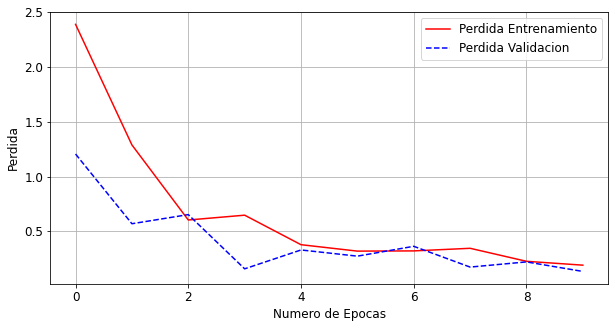

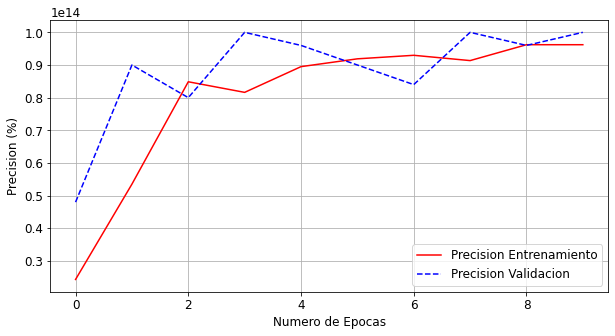

In [24]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

Found 35 images belonging to 7 classes.
              precision    recall  f1-score   support

           0     1.0000    0.8000    0.8889         5
           1     1.0000    1.0000    1.0000         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     0.8333    1.0000    0.9091         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5

    accuracy                         0.9714        35
   macro avg     0.9762    0.9714    0.9711        35
weighted avg     0.9762    0.9714    0.9711        35



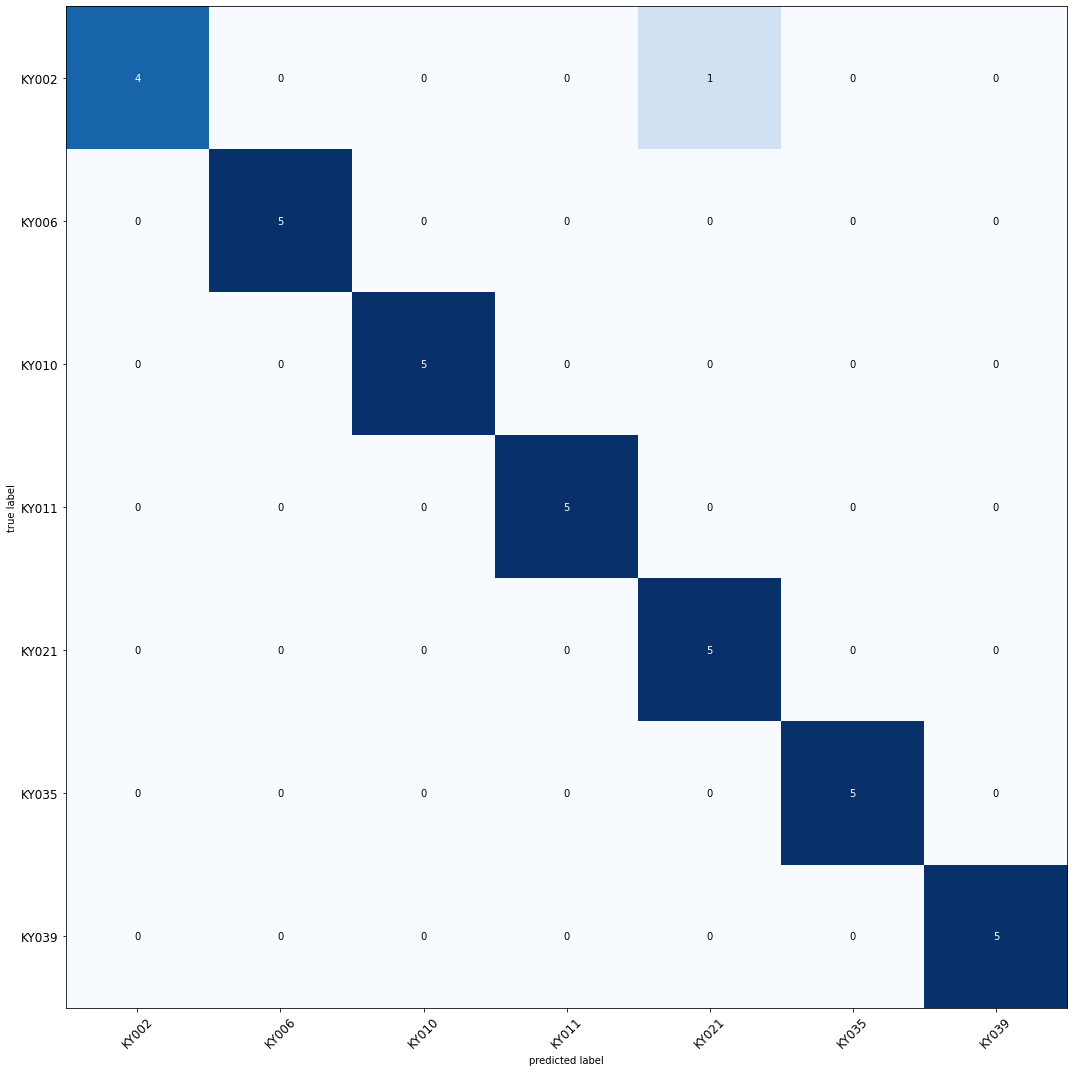

In [10]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

#Clases a clasificar
names = ['KY002','KY006','KY010','KY011','KY021','KY035','KY039']

#Directorio de las imágenes de test
test_data_dir = 'imagenes/test'  
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("modelos/sensores_VGG16.h5")
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(15,15), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))